In [1]:
!pip install split_folders
import splitfolders
splitfolders.ratio("/kaggle/input/leukemia/Original", output="./", seed=1337, ratio=(.6, .2, .2), group_prefix=None) # default values

Copying files: 3256 files [00:22, 145.65 files/s]


In [2]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D, Reshape, GlobalMaxPooling2D
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from keras.utils import plot_model

In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.efficientnet import EfficientNetB6
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import efficientnet
import tensorflow.keras.layers as L

import tensorflow as tf
import tensorflow_addons as tfa

In [4]:
tf.__version__

'2.11.0'

In [5]:
!pip install -q image-classifiers
from classification_models.keras import Classifiers

In [6]:
seresnext50, preprocess_input_srnxt = Classifiers.get('seresnext50')


In [7]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S

In [8]:
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efnet
from tensorflow.keras.applications.xception import preprocess_input as preprocess_input_xception
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as preprocess_input_efv2
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet


In [9]:
ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", ngpu)

if ngpu>1:
    print("Using multi GPU")
    strategy = tf.distribute.MirroredStrategy()
    
AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Num GPUs Available:  2
Using multi GPU
REPLICAS: 2


In [10]:
preprocess_input_func = preprocess_input_srnxt

In [11]:
import os
NUM_CLASSES = len(os.listdir(r'./test'))

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input_func) #included in our dependencies

train_generator=train_datagen.flow_from_directory(r'./train', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=24,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input_func) #included in our dependencies

val_generator=val_datagen.flow_from_directory(r'./val', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=24,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 1952 images belonging to 4 classes.
Found 649 images belonging to 4 classes.


In [12]:
# !pip install -q efficientnet
# !pip install -q image-classifiers

# import efficientnet.tfkeras as efn
# from classification_models.keras import Classifiers

In [13]:
from keras import layers
from keras import backend as K
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda


In [14]:
METRICS = [keras.metrics.CategoricalAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]

In [15]:
def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature.shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

In [16]:
IMG_SIZE = 224
n_classes = 4

inp = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
# x1 = layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)(inp)
# x2 = layers.experimental.preprocessing.Rescaling(1./255)(x1)
# x3 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
#                    padding = 'same', input_shape=(IMG_SIZE,IMG_SIZE,3))(x2)
x3 = seresnext50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))(inp)

# x4 = cbam_block(x3)
# x5 = layers.BatchNormalization(axis=-1)(x4)
# x6 = layers.MaxPool2D(pool_size=(2, 2))(x5)
# x7 = layers.Conv2D(filters=64, kernel_size=(3, 3), 
#                    activation='relu', padding = 'same')(x6)
# x8 = cbam_block(x7)
# x9 = layers.BatchNormalization(axis=-1)(x8)
# x10 = layers.MaxPool2D(pool_size=(2, 2))(x9)
# x11 = layers.Conv2D(filters=128, kernel_size=(3, 3), 
#                     activation='relu', padding = 'same')(x10)
# x12 = cbam_block(x11)
# x13 = layers.BatchNormalization(axis=-1)(x12)
# x14 = layers.MaxPool2D(pool_size=(2, 2), padding='same')(x13)
# x15 = layers.Conv2D(filters=256, kernel_size=(3, 3), 
#                       activation='relu', padding = 'same')(x14)
# x16 = cbam_block(x15)
# x17 = layers.BatchNormalization(axis=-1)(x4)
# x18 = layers.MaxPool2D(pool_size=(2, 2), padding='same')(x17)
# y1 = layers.Flatten()(x17)
# y2 = layers.Dense(512, activation='relu')(y1)
# y3 = layers.Dense(128, activation='relu')(y2)
# y4 = layers.Dropout(0.25)(y3)
sr = layers.GlobalAveragePooling2D()(x3)
y = layers.Dense(n_classes, activation='softmax')(sr)   


model_CBAM = tf.keras.Model(inp, y)

104679448/104679448 [==============================] - 1s 0us/step


In [17]:
model_CBAM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                   loss='categorical_crossentropy', 
                   metrics=METRICS)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model (Functional)          (None, 7, 7, 2048)        25579120  
                                                                 
 global_average_pooling2d_16  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 25,587,316
Trainable params: 25,519,092
Non-trainable params: 68,224
_________________________________________________________________
None


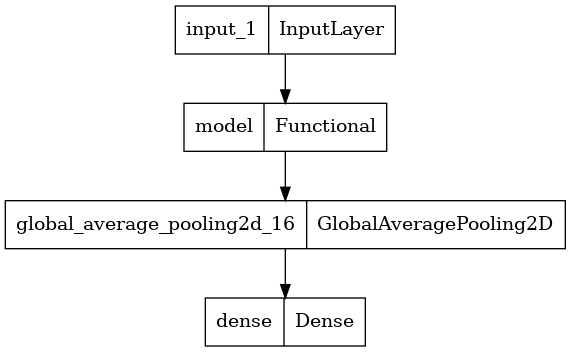

In [18]:

# md = EfficientNetB6(weights='imagenet', include_top=False,  input_shape=(224, 224, 3), pooling='avg')
# model = keras.models.Sequential([
#     md,
#     keras.layers.Dense(NUM_CLASSES)
# ])

# model = compileNewModel(dim = 224)
model = model_CBAM

# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file='model.pdf', dpi=2000)
plot_model(model)

In [19]:
earlystop=EarlyStopping(patience=3) 
learning_rate_reduction=ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.1,min_lr=0.0000000001) 
callback=[learning_rate_reduction]

loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# model.compile(optimizer=Adam(lr=0.00001),loss=loss, metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size
history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train, validation_data=val_generator, validation_steps=step_size_val, epochs=25, callbacks=callback)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/25
81/81 [==============================] - 210s 791ms/step - loss: 0.1378 - accuracy: 0.9538 - precision: 0.9797 - recall: 0.9253 - auc: 0.9972 - val_loss: 0.2681 - val_accuracy: 0.9213 - val_precision: 0.9341 - val_recall: 0.8966 - val_auc: 0.9859 - lr: 1.0000e-04
Epoch 2/25
81/81 [==============================] - 55s 680ms/step - loss: 0.0166 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9943 - auc: 0.9999 - val_loss: 0.1544 - val_accuracy: 0.9552 - val_precision: 0.9552 - val_recall: 0.9537 - val_auc: 0.9933 - lr: 1.0000e-04
Epoch 3/25
81/81 [==============================] - 56s 697ms/step - loss: 0.0135 - accuracy: 0.9959 - precision: 0.9964 - recall: 0.9953 - auc: 1.0000 - val_loss: 0.0374 - val_accuracy: 0.9877 - val_precision: 0.9877 - val_recall: 0.9877 - val_auc: 0.9997 - lr: 1.0000e-04
Epoch 4/25
81/81 [==============================] - 57s 703ms/step - loss: 0.0183 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9933 - auc: 0.9999 - val_loss: 0.0166 - val_

In [20]:
# serialize model to JSON
model_json = model.to_json()
with open("DenseNet201.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save("zooEf.h5")
print("Saved model to disk")

Saved model to disk


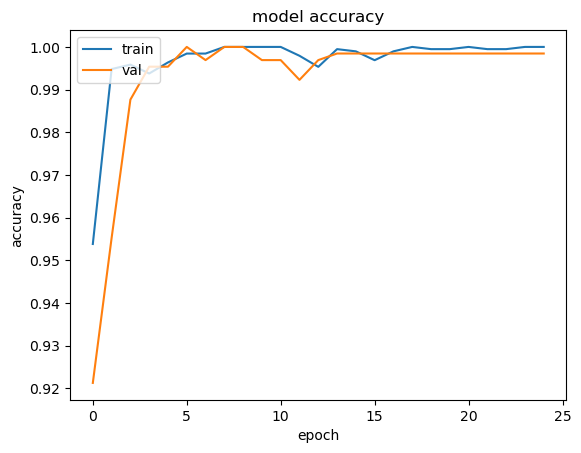

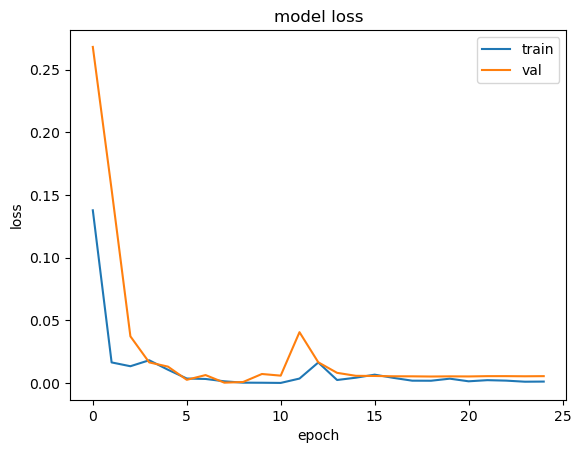

<Figure size 640x480 with 0 Axes>

In [21]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('accu.png')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
plt.savefig('loss.png')

Found 655 images belonging to 4 classes.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


27/27 [==============================] - 11s 173ms/step
                          Filename Predictions
0        Benign/WBC-Benign-007.jpg      Benign
1        Benign/WBC-Benign-009.jpg      Benign
2        Benign/WBC-Benign-010.jpg      Benign
3        Benign/WBC-Benign-023.jpg      Benign
4        Benign/WBC-Benign-024.jpg      Benign
..                             ...         ...
650  Pro/WBC-Malignant-Pro-775.jpg         Pro
651  Pro/WBC-Malignant-Pro-780.jpg         Pro
652  Pro/WBC-Malignant-Pro-782.jpg         Pro
653  Pro/WBC-Malignant-Pro-793.jpg         Pro
654  Pro/WBC-Malignant-Pro-794.jpg         Pro

[655 rows x 2 columns]
654 1
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       102
           1       0.99      1.00      1.00       197
           2       1.00      1.00      1.00       194
           3       1.00      1.00      1.00       162

   micro avg       1.00      1.00      1.00       655
   macro avg       1.00 

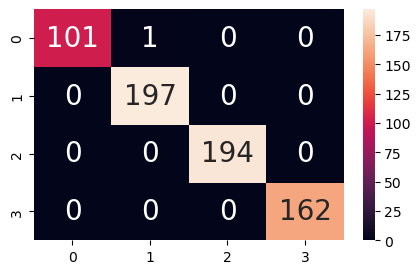

In [22]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input_func)
batch_size=24
pred_dir = r'./test'
test_generator = test_datagen.flow_from_directory(
    directory=pred_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)
#test_generator.reset() 
pred=model.predict_generator(test_generator,verbose=1,steps=test_generator.n/batch_size)

predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(results)


import pandas as pd
t_counter = 0
f_counter = 0

file_arr = []
pred_arr = []

for index, row in results.iterrows():
    #print(row['Filename'].split('/')[0], row['Predictions'])
    file_arr.append(row['Filename'].split('/')[0])
    pred_arr.append(row['Predictions'])
    if row['Filename'].split('/')[0] == row['Predictions']:
        t_counter = t_counter + 1
    else:
        f_counter = f_counter + 1
print(t_counter, f_counter)

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
test_y = labelencoder.fit_transform(file_arr)
pred_y = labelencoder.fit_transform(pred_arr)
test_y_or = test_y
pred_y_or = pred_y

from keras.utils import np_utils
test_y = np_utils.to_categorical(test_y, NUM_CLASSES)
pred_y = np_utils.to_categorical(pred_y, NUM_CLASSES)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

from sklearn.metrics import accuracy_score
score = accuracy_score(test_y, pred_y)
print(score*100)

from sklearn.metrics import confusion_matrix
c=confusion_matrix(test_y_or, pred_y_or)
x = c.diagonal()/c.sum(axis=1)
for i in range(len(x)):
    print('Class ', i, ' Accuracy: ', x[i])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (5,3))
sns.heatmap(c, annot=True, annot_kws={"size": 20}, fmt='d')
plt.savefig('cm.png')